In [4]:
import pandas as pd
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, date
import numpy as np
from googlemaps import Client as GoogleMaps
import folium
from folium import Choropleth, Circle, Marker
from folium.plugins import MarkerCluster
from geopy.geocoders import Nominatim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
import category_encoders as ce
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from imblearn.over_sampling import SMOTE
from sklearn.neighbors import KNeighborsRegressor

ModuleNotFoundError: No module named 'googlemaps'

In [5]:
warnings.filterwarnings('ignore')

In [6]:
sample = pd.read_csv('SampleSubmission.csv')
sample

FileNotFoundError: [Errno 2] No such file or directory: 'SampleSubmission.csv'

In [7]:
demographic = pd.read_csv('traindemographics.csv')
demographic.head()

FileNotFoundError: [Errno 2] No such file or directory: 'traindemographics.csv'

Description of demographic data:
- customerid (Primary key used to merge to other data)
- birthdate (date of birth of the customer)
- bank_account_type (type of primary bank account)
- longitude_gps
- latitude_gps
- bank_name_clients (name of the bank)
- bank_branch_clients (location of the branch - not compulsory - so missing in a lot of the cases)
- employment_status_clients (type of employment that customer has)
- level_of_education_clients (highest level of education)


In [ ]:
performance = pd.read_csv('trainperf.csv')
performance.head()

Performance data (trainperf.csv) : This is the repeat loan that the customer has taken for which we need to predict the performance of. Basically, we need to predict whether this loan would default given all previous loans and demographics of a customer.
Description of data:
- customerid (Primary key used to merge to other data)
- systemloanid (The id associated with the particular loan. The same customerId can have multiple systemloanid’s for each loan he/she has taken out)
- loannumber (The number of the loan that you have to predict)
- approveddate (Date that loan was approved)
- creationdate (Date that loan application was created)
- loanamount (Loan value taken)
- totaldue (Total repayment required to settle the loan - this is the capital loan value disbursed +interest and fees)
- termdays (Term of loan)
- referredby (customerId of the customer that referred this person - is missing, then not referred)
- good_bad_flag (good = settled loan on time; bad = did not settled loan on time) - this is the target variable that we need to predict

In [ ]:
previous = pd.read_csv('trainprevloans.csv')
previous.head()

Previous loans data (trainprevloans.csv) : This dataset contains all previous loans that the customer had prior to the loan above that we want to predict the performance of. Each loan will have a different systemloanid, but the same customerid for each customer.
Description of data:
- customerid (Primary key used to merge to other data)
- systemloanid (The id associated with the particular loan. The same customerId can have multiple systemloanid’s for each loan he/she has taken out)
- loannumber (The number of the loan that you have to predict)
- approveddate (Date that loan was approved)
- creationdate (Date that loan application was created)
- loanamount (Date that loan application was created)
- totaldue (Total repayment required to settle the loan - this is the capital loan value disbursed +interest and fees) termdays (Term of loan)
- closeddate (Date that the loan was settled)
- referredby (customerId of the customer that referred this person - is missing, then not refrerred)
- firstduedate (Date of first payment due in cases where the term is longer than 30 days. So in the case where the term is 60+ days - then there are multiple monthly payments due - and this dates reflects the date of the first payment)
- firstrepaiddate (Actual date that he/she paid the first payment as defined above)

In [ ]:
customerCheck = demographic.assign(InPerformance=demographic.customerid.isin(performance.customerid), InPrevious=demographic.customerid.isin(previous.customerid))
customerCheck = customerCheck[['customerid','InPerformance','InPrevious']]

In [ ]:
demographic.assign(InPerformance=demographic.customerid.isin(performance.customerid), InPrevious=demographic.customerid.isin(previous.customerid))


In [ ]:
customerCheck

In [ ]:
customerCheck.groupby(['InPerformance','InPrevious']).value_counts()

In [ ]:
demographic.info()

In [ ]:
performance.info()

In [ ]:
previous.info()

In [ ]:
previous.head()

In [ ]:
performance.head()

In [ ]:
performance.loc[performance['customerid'] == '8a858e105bd92644015bd9db3a0f3be2']

In [ ]:
previous.loc[previous['customerid'] == '8a858e105bd92644015bd9db3a0f3be2']

In [ ]:
duplicate = demographic[demographic.duplicated()]
 
print("Duplicate Rows :")
 
# Print the resultant Dataframe
duplicate

In [ ]:
demographic.drop_duplicates(inplace=True)

In [ ]:
customerCheck = demographic.assign(InPerformance=demographic.customerid.isin(performance.customerid), InPrevious=demographic.customerid.isin(previous.customerid))
customerCheck = customerCheck[['customerid','InPerformance','InPrevious']]

In [ ]:
customerCheck.groupby(['InPerformance','InPrevious']).value_counts()


Create the first model which would predict for non-new customers based on demographic and previous loans data.
Create the second model which predict for new customers based on just demographic data.

### Determining how the dataframes are going to be concatenated.

#### Checking the common columns between the data sets

##### customerid

Performance dataframe has 18183 entries and previous has 4368 entries.

In [ ]:
performanceids = pd.DataFrame(performance['customerid'])
performanceids

In [ ]:
performanceids.groupby('customerid').value_counts().nlargest()

In [ ]:
previousids = pd.DataFrame(previous['customerid'])
previousids

In [ ]:
previousids.groupby('customerid').value_counts().nlargest()

From the analysis above, one can see that the most times a customer appears in the performance data is once, whereas the most times a customer appears in the previous data is 26 times. This means there is a one to many relationship between the two dataframes with previous being on the many side. This means it is more ideal to add the 'performance' dataframe to the previous dataframe.

##### adding the performance dataframe to the previous loans dataframe

Between the two dataframes,there are a number of similar columns. To add the two dataframes together, the column names of the incoming dataframe,'performance', will be changed to be able to distinguish the columns.

In [ ]:
performance.columns

In [ ]:
previous.columns

From the cells above, we can see the similar columns: 
customerid, systemloanid,loannumber,approveddate,creationdate,loanamount,totaldue,termdays and referred by. 
All of these columns,apart from customerid and systemloanid, will be renamed now.
Customerid and systemloanid will not be renamed because they are going to be dropped ahead.

In [ ]:
performance.columns = ['customerid','systemloanid','perf_loannumber','perf_approveddate','perf_creationdate','perf_loanamount','perf_totaldue','perf_termdays','perf_referredby','good_bad_flag']

In [ ]:
performance.columns

In [ ]:
previous.info()

In [ ]:
previousCustomers = pd.merge(previous, performance, on='customerid')

In [ ]:
previousCustomers

In [ ]:
previousCustomers.info()

Dropping the systemloanid columns

In [ ]:
previousCustomers.drop(['systemloanid_x','systemloanid_y'],axis=1,inplace=True)
previousCustomers.info()

In [ ]:
previousCustomers = pd.merge(previousCustomers, demographic, on='customerid')

##### adding demographic data to previous customers dataframe

In [ ]:
previousCustomers.info()

##### looking at the data contained in the columns now to determine what columns will be used to train the model

*columns containing non-numerical data*

In [ ]:
categorical = [var for var in previousCustomers.columns if previousCustomers[var].dtype=='O']

print('There are {} categorical variables \n'.format(len(categorical)))

print('They are: ', categorical)

In [ ]:
previousCustomers[categorical].head()

##### customer id column: Primary key used to merge to other data

customer id column has an averagely high cardinality and is used to uniquely identify the customers. This feature will not be used for model training.

##### approved date column : Date that loan was approved

approved date column has a high cardinality. It will not be used because we don't believe the approval data for a loan holds a significance towards whether a loan may be bad or good.

##### creation date column : Date that loan application was created

creation date column has a high cardinality. It will not be selected as feature to train the model because we do not believe the creation date for a loan holds a significance towards whether a loan may be bad or good

##### closed date column : Date that the loan was settled

closed date column has a high cardinality. Since we have a loan creation date, we can arrive at how long the loan was active until it was settled. This time period can then be used as a new feature to train the model. Let's look more at the closed dates and see if there is a relationship  between the closing dates and whether a loan may be good or bad.

In [ ]:
closedDates = previousCustomers[['closeddate','good_bad_flag']]
closedDates

 going to break down the date and individual components, ie year, month and day and time. Then proceed to gain insights into the relationship between date/time and bad/good loans

In [ ]:
closedDates['closeddate'] = pd.to_datetime(closedDates['closeddate'])

In [ ]:
closedDates.info()

In [ ]:
closedDates['year'] = closedDates['closeddate'].dt.year
closedDates.head()

In [ ]:
closedDates['month'] = closedDates['closeddate'].dt.month
closedDates.head()

In [ ]:
closedDates['day'] = closedDates['closeddate'].dt.day
closedDates.head()

In [ ]:
closedDates['hourOfDay'] = closedDates['closeddate'].dt.hour
closedDates.head()

In [ ]:
closedDates['hourOfDay'].unique()

the hour is recorded in 24 hour clock which is desirable so we can differentiate between the times i.e 3 in the morning and 3 in the evening.

In [ ]:
year_group = closedDates.groupby(['year'])['good_bad_flag'].value_counts()
year_group

In [ ]:

#plt.subplot(4,1,1)
#yearLook = closedDates[['year', 'good_bad_flag']]
closedDates.groupby(['year','good_bad_flag']).size().unstack().plot(kind='bar',stacked=True)
plt.xlabel('Years')
plt.ylabel('Number of bad/good loans')

plt.title('A look at the number of good and bad loans through the years 2016 and 2017')

#plt.subplot(4,1,2)
#plt.title('A look at the number of good and bad loans throughout the years')

f = plt.gcf()
f.set_figwidth(5) 

In [ ]:
closedDates.groupby(['month','good_bad_flag']).size().unstack().plot(kind='bar',stacked=True,rot=0)
plt.xlabel('Months of the year')
plt.ylabel('Number of bad/good loans')
plt.title('A look at the number of good and bad loans through the months of the year')

f = plt.gcf()
f.set_figwidth(5) 

In [ ]:
closedDates.groupby(['day','good_bad_flag']).size().unstack().plot(kind='bar',stacked=True,rot=0)
plt.xlabel('Months of the year')
plt.ylabel('Number of bad/good loans')
plt.title('A look at the number of good and bad loans through the days of a month')

f = plt.gcf()
f.set_figwidth(15) 

In [ ]:
plt.figure(figsize=(15,30))
closedDates.groupby(['hourOfDay','good_bad_flag']).size().unstack().plot(kind='bar',stacked=True)
plt.xlabel('hours')
plt.ylabel('Number of bad/good loans')

plt.title('A look at the number of good and bad loans through the hours of day')

f = plt.gcf()
f.set_figwidth(15) 

I do not think that the year serves as a significant feature to train this model and therefore it will not be used going forward. The months, day and hour of the day serve as good features to use to train this model.

In [ ]:
previousCustomers.head()

Let's also look at the duration of the lifetime of the loan i.e from when it was created to when it was fully paid back. 

In [ ]:
previousCustomers['closeddate'] = pd.to_datetime(previousCustomers['closeddate'])
previousCustomers['creationdate'] = pd.to_datetime(previousCustomers['creationdate'])

In [ ]:
previousCustomers['loanlifewithdelta'] = ((previousCustomers.closeddate - previousCustomers.creationdate)/np.timedelta64(1, 'D'))
previousCustomers['loanlifenodelta'] = previousCustomers.closeddate - previousCustomers.creationdate
previousCustomers.head()

We will use the loanlifewithdelta column as a new feature to train our model with

In [ ]:
previousCustomers.drop(['loanlifenodelta'],axis=1, inplace=True)

We are going to list out the columns that have been selected to train our model to keep track of them as the notebook progresses:
1. period take to settle the loan(lifetime of loan): previousCustomers[loanlifewithdelta]

##### referredby column

In [ ]:
previousCustomers['referredby'].isnull().sum()

In [ ]:
len(previousCustomers['referredby'].unique())

In [ ]:
previousCustomers['referredby'].unique()

The referredby column has a high cardinality and the column value doesn't particularly give any relevance to the model. The details of the referee may be useful though and so will be considered.

##### first_due_date and first_repaid_date columns

This columns individually don't provide significant features but when used together might prove to be more useful.
The difference between the two columns can tell us if a customer was prompt on making their payments.

In [ ]:
loanrepayment = previousCustomers[['firstduedate','firstrepaiddate','good_bad_flag']]

In [ ]:
loanrepayment.head()

In [ ]:
loanrepayment['firstduedate'] = pd.to_datetime(loanrepayment['firstduedate'])
loanrepayment['firstrepaiddate'] = pd.to_datetime(loanrepayment['firstrepaiddate'])

In [ ]:
loanrepayment['firstrepaymentlapsewithdelta'] = ((loanrepayment.firstduedate - loanrepayment.firstrepaiddate)/np.timedelta64(1, 'D'))
loanrepayment['firstrepaymentlapsewithnodelta'] = loanrepayment.firstduedate - loanrepayment.firstrepaiddate
loanrepayment.head()

Updating selected features:
1. period take to settle the loan(lifetime of loan): previousCustomers[loanlifewithdelta]
2. first repayment day status: loanrepayment[firstrepaymentlapsewithdelta]

In [ ]:
##thinking of having a column showing the days and another column saying whether it was before or after the due date

The next cells are looking at the data from the performance dataframe. Those columns that were also present in the previous dataframe and were dropped as features above, will also be dropped as features below. 

##### perf_referredby

In [ ]:
len(previousCustomers['perf_referredby'].unique())

In [ ]:
previousCustomers['perf_referredby'].isnull().sum()

There are a number of null values within this columns and we cannot easily replace the missing values. This column will therefore not be used going forward

##### birthdate

This column may not be significant as it is for training our model. It may be better to get the actual age of the customers rather than using there birthdates.

So let us get the actual ages of the customers.

In [ ]:
#converting birthdate column to datetime
previousCustomers['birthdate'] = pd.to_datetime(previousCustomers['birthdate'])

In [ ]:
customerAge = previousCustomers[['birthdate','good_bad_flag']]
customerAge.head()

In [ ]:
currentDate = date.today()

In [ ]:
currentDate

In [ ]:
customerAge['age'] = round(((pd.datetime.now()- customerAge['birthdate'])/np.timedelta64(1, 'Y')),1)

In [ ]:
customerAge.tail()

In [ ]:
customerAge.loc[customerAge['good_bad_flag']=='Good','flag'] = 0
customerAge.loc[customerAge['good_bad_flag']=='Bad','flag'] = 1
customerAge.head()

In [ ]:
badLoans = customerAge.loc[customerAge['good_bad_flag'] == 'Bad']

In [ ]:
badLoans.to_csv('agesAndBadLoans.csv')

In [ ]:
customerAge.to_csv('allLoansAndAges.csv')

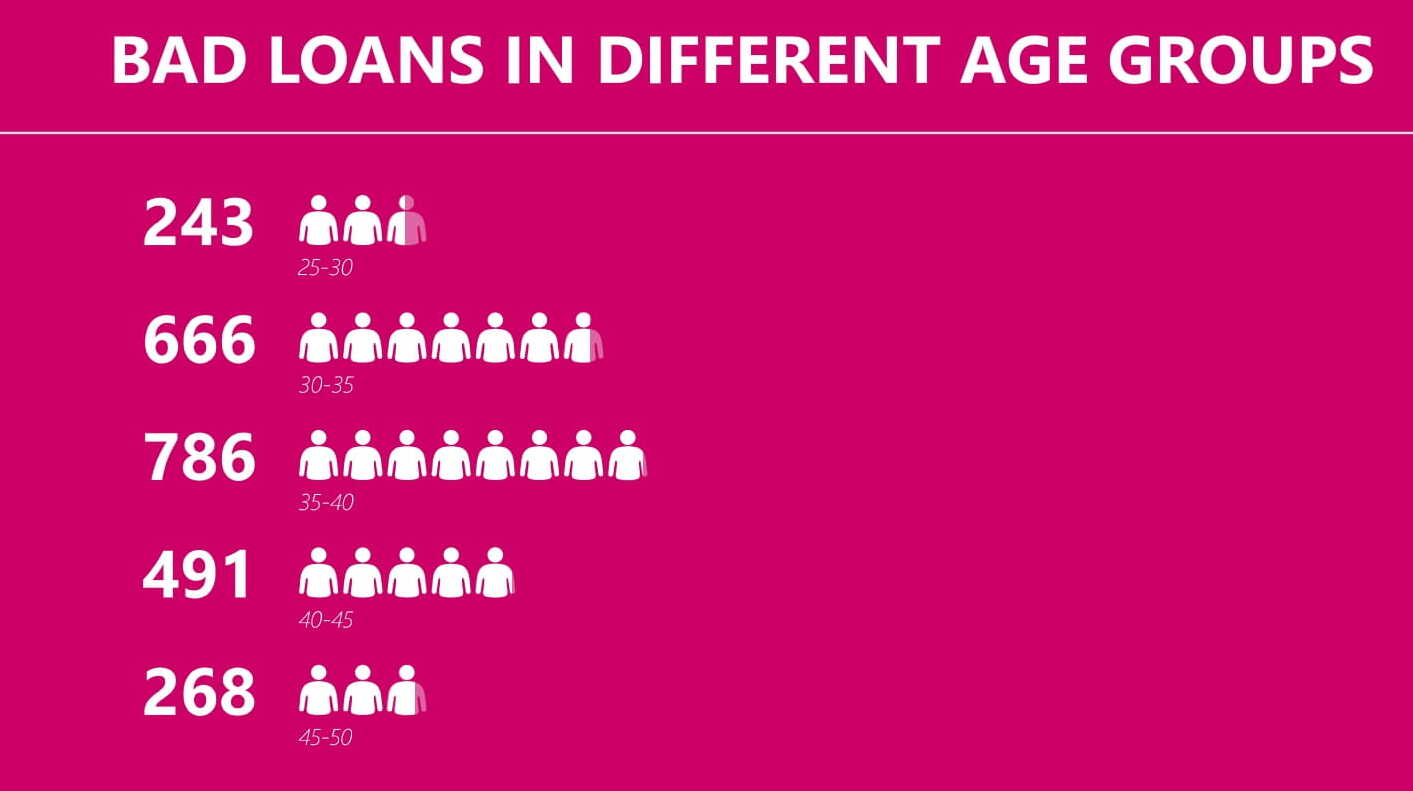

add graph showing good loans

so we shall use the ages of people to train our model instead of their birthdate

Updating selected features:
1. period take to settle the loan(lifetime of loan): previousCustomers[loanlifewithdelta]
2. first repayment day status: loanrepayment[firstrepaymentlapsewithdelta]
3. ages of the customers: birthdate[age]

##### bank account type

In [ ]:
len(previousCustomers['bank_account_type'].unique())

In [ ]:
testdemo = pd.read_csv('testdemographics.csv')

In [ ]:
len(testdemo['bank_account_type'].unique())

In [ ]:
previousCustomers['bank_account_type'].isnull().sum()

In [ ]:
previousCustomers['bank_account_type'].unique()

This feature shall be used to train our model

Updating selected features:
1. period take to settle the loan(lifetime of loan): previousCustomers[loanlifewithdelta]
2. first repayment day status: loanrepayment[firstrepaymentlapsewithdelta]
3. ages of the customers: birthdate[age]
4. the type of bank account: previousCustomers[bank_account_type]

##### bank_name_clients

In [ ]:
previousCustomers['bank_name_clients'].unique()

In [ ]:
len(previousCustomers['bank_name_clients'].unique())

In [ ]:
previousCustomers['bank_name_clients'].isnull().sum()

In [ ]:
len(testdemo['bank_name_clients'].unique())

This column will be used to train the model

Updating selected features:
1. period take to settle the loan(lifetime of loan): previousCustomers[loanlifewithdelta]
2. first repayment day status: loanrepayment[firstrepaymentlapsewithdelta]
3. ages of the customers: birthdate[age]
4. the type of bank account: previousCustomers[bank_account_type]
5. the bank name of the clients: previousCustomers[bank_name_clients]

We can also have a look the bad loans and good loans according to the different banks

In [ ]:
bankStats = previousCustomers[['bank_name_clients','good_bad_flag']]

In [ ]:

#plt.subplot(4,1,1)
#yearLook = closedDates[['year', 'good_bad_flag']]
bankStats.groupby(['bank_name_clients','good_bad_flag']).size().unstack().plot(kind='bar',stacked=True,rot=45)
plt.xlabel('Banks')
plt.ylabel('Number of bad/good loans')

plt.title('A look at the number of good and bad loans in different banks')

#plt.subplot(4,1,2)
#plt.title('A look at the number of good and bad loans throughout the years')

f = plt.gcf()
f.set_figwidth(15) 

In [ ]:
# FIND THE AGE RANGE OF THE PEOPLE WHO ARE GOING TO THE DIFFERENT BANKS,
#use pivot table and see the most common bank in the 
#age range and see if there's a connection

##### bank branch clients

In [ ]:
previousCustomers['bank_branch_clients'].unique()

In [ ]:
previousCustomers['bank_branch_clients'].isnull().sum()

This column will not be used to train our model

##### employment status clients

In [ ]:
previousCustomers['employment_status_clients'].unique()

In [ ]:
testdemo['employment_status_clients'].unique()

In [ ]:
previousCustomers['employment_status_clients'].isnull().sum()

In [ ]:
previousCustomers['employment_status_clients'].fillna("Unemployed", inplace=True)

Updating selected features:
1. closed date month: closedDates[month]
2. closed date day: closedDates[day]
3. closed date hour of day: closedDates[hourOfDay]
4. period take to settle the loan(lifetime of loan): previousCustomers[loanlifewithdelta]
5. first repayment day status: loanrepayment[firstrepaymentlapsewithdelta]
6. ages of the customers: birthdate[age]
7. the type of bank account: previousCustomers[bank_account_type]
8. the bank name of the clients: previousCustomers[bank_name_clients]
9. the employment status of clients: previousCustomers[employment_status]

We can also see how the number of bad and good loans relates to a person's employment status

In [ ]:
jobstatus = previousCustomers[['employment_status_clients','good_bad_flag']]

In [ ]:

#plt.subplot(4,1,1)
#yearLook = closedDates[['year', 'good_bad_flag']]
jobstatus.groupby(['employment_status_clients','good_bad_flag']).size().unstack().plot(kind='bar',stacked=True,rot=0)
plt.xlabel('Employment status')
plt.ylabel('Number of bad/good loans')

plt.title('A look at the number of good and bad loans for different employment statuses')

#plt.subplot(4,1,2)
#plt.title('A look at the number of good and bad loans throughout the years')

f = plt.gcf()
f.set_figwidth(15) 

##### level of education of clients

In [ ]:
previousCustomers['level_of_education_clients'].unique()

In [ ]:
previousCustomers['level_of_education_clients'].isnull().sum()

The number of uneducated Nigerians is actually large and therefore it is safe to assume those that have no level of education selected are not. Therefore the missing values will be replaced with No-Education-Level

In [ ]:
previousCustomers['level_of_education_clients'].fillna('No-Education-Level', inplace=True)

In [ ]:
#encoding the level of education
level_of_education = pd.get_dummies(previousCustomers.level_of_education_clients, drop_first=True)
level_of_education

Updating selected features:
1. closed date month: closedDates[month]
2. closed date day: closedDates[day]
3. closed date hour of day: closedDates[hourOfDay]
4. period take to settle the loan(lifetime of loan): previousCustomers[loanlifewithdelta]
5. first repayment day status: loanrepayment[firstrepaymentlapsewithdelta]
6. ages of the customers: birthdate[age]
7. the type of bank account: previousCustomers[bank_account_type]
8. the bank name of the clients: previousCustomers[bank_name_clients]
9. the employment status of clients: previousCustomers[employment_status]
10. the level of education of clients: previousCustomers[level_of_education_clients]

We can still look at the how the level of education plays out in the matter of bad and good loans

In [ ]:
educationlevel = previousCustomers[['level_of_education_clients','good_bad_flag']]

In [ ]:

#plt.subplot(4,1,1)
#yearLook = closedDates[['year', 'good_bad_flag']]
educationlevel.groupby(['level_of_education_clients','good_bad_flag']).size().unstack().plot(kind='bar',stacked=True,rot=0)
plt.xlabel('Level of education')
plt.ylabel('Number of bad/good loans')

plt.title('A look at the number of good and bad loans for different employment statuses')

#plt.subplot(4,1,2)
#plt.title('A look at the number of good and bad loans throughout the years')

f = plt.gcf()
f.set_figwidth(15) 

So we have gone through the non-numerical features of our data and have selected the following columns as features to train our model with:
1. period take to settle the loan(lifetime of loan): previousCustomers[loanlifewithdelta]
2. first repayment day status: loanrepayment[firstrepaymentlapsewithdelta]
3. ages of the customers: birthdate[age]
4. the type of bank account: previousCustomers[bank_account_type]
5. the bank name of the clients: previousCustomers[bank_name_clients]
6. the level of education of clients: previousCustomers[level_of_education_clients]

#### Now to look at the numerical columns

In [ ]:
numerical = [var for var in previousCustomers.columns if previousCustomers[var].dtype!='O']

print('There are {} numerical variabes \n'.format(len(numerical)))

print('They are: ', numerical)

We are going to ignore creationdate, closeddate, birthdate, loanlifewithdelta and loanlifewithnodelata as these have been dealt with and discussed while looking at the categorical features.

In [ ]:
numColumns= previousCustomers[['loannumber','loanamount','totaldue','termdays','closeddate','perf_loannumber','perf_loanamount','perf_totaldue','perf_termdays','longitude_gps','latitude_gps']]

In [ ]:
numColumns.head()

Below we add some of the numerical columns generated from the categorical features. These added columns are going to be treated as numerical i.e a person's age, the lifetime of a loan, the time a person took to complete the first repayment day.

In [ ]:
numColumns = pd.concat([numColumns, customerAge['age'],previousCustomers['loanlifewithdelta'],loanrepayment['firstrepaymentlapsewithdelta'],previousCustomers['good_bad_flag']],axis=1)

In [ ]:
numColumns.tail()

In [ ]:
numColumns.info()

In [ ]:
numColumns.drop(['closeddate'],axis=1,inplace=True)

From the first repayment lapse column, we are going to create two new columns:
1. The first, LateFirstPay, will show whether someone was late in making the first repayment date and by how many days
2. The second, EarlyFirstPay, will show whether someone was early in making the first repayment date and by how many days


In [ ]:
numColumns.loc[numColumns['firstrepaymentlapsewithdelta'] < 0, 'LateFirstPay'] = numColumns['firstrepaymentlapsewithdelta']
numColumns.loc[numColumns['firstrepaymentlapsewithdelta'] < 0, 'EarlyFirstPay'] = 0
numColumns.loc[numColumns['firstrepaymentlapsewithdelta'] >= 0, 'LateFirstPay'] = 0
numColumns.loc[numColumns['firstrepaymentlapsewithdelta'] >= 0, 'EarlyFirstPay'] = numColumns['firstrepaymentlapsewithdelta']

In [ ]:
numColumns

In [ ]:
numColumns.info()

In [ ]:
numColumns.drop(['firstrepaymentlapsewithdelta'], axis=1, inplace=True)

Let's have a look at if there are outliers in our data using boxplot

In [ ]:
plt.figure(figsize=(15,10))

plt.subplot(2,2,1)
fig = numColumns.boxplot(column='loannumber')
fig.set_ylabel('Loan number')

plt.subplot(2,2,2)
fig = numColumns.boxplot(column='loanamount')
fig.set_ylabel('Loan amount')

plt.subplot(2,2,3)
fig = numColumns.boxplot(column='totaldue')
fig.set_ylabel('Total due')

plt.subplot(2,2,4)
fig = numColumns.boxplot(column='age')
fig.set_ylabel('Age')

In [ ]:
plt.figure(figsize=(15,10))

plt.subplot(1,2,1)
fig = numColumns.boxplot(column='latitude_gps')
fig.set_ylabel('Latitude')

plt.subplot(1,2,2)
fig = numColumns.boxplot(column='longitude_gps')
fig.set_ylabel('Longitude')



The outliers via longitude and latitude may be atttibuted to people who are outside Nigeria.

More Eda can be done via the latitude and longitude

##### splitting data into target and feature

In [ ]:
newdf = pd.concat([numColumns, 
                  pd.get_dummies(previousCustomers.bank_account_type),
                  pd.get_dummies(previousCustomers.bank_name_clients),
                  pd.get_dummies(previousCustomers.employment_status_clients),
                  pd.get_dummies(previousCustomers.level_of_education_clients)], axis=1)

newdf

In [ ]:
newdf.columns

In [ ]:
X = newdf.drop(['good_bad_flag'], axis=1)
y = newdf['good_bad_flag']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state= 4)

In [ ]:
X_train.shape, X_test.shape

In [ ]:
X_train.columns

No missing values

##### Scaling of the data

In [ ]:
numColumns.columns

In [ ]:
plt.figure(figsize=(15,10))

plt.subplot(2,2,1)
fig = sns.distplot(numColumns['loannumber'])
#fig.set_ylabel('Loan number')

plt.subplot(2,2,2)
fig = sns.distplot(numColumns['loanamount'])
#fig.set_ylabel('Loan amount')

plt.subplot(2,2,3)
fig = sns.distplot(numColumns['totaldue'])
#fig.set_ylabel('Total due')

plt.subplot(2,2,4)
fig = sns.distplot(numColumns['age'])
#fig.set_ylabel('Age')

In [ ]:
plt.figure(figsize=(15,10))

plt.subplot(2,2,1)
fig = sns.distplot(numColumns['longitude_gps'])
#fig.set_ylabel('Loan number')

plt.subplot(2,2,2)
fig = sns.distplot(numColumns['latitude_gps'])
#fig.set_ylabel('Loan amount')

In [ ]:
cols = X_train.columns

In [ ]:
#Going to use a standard scaler
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
##### Dealing with imbalance data

## Logistic Regression
### with imbalanced data

In [ ]:
logreg = LogisticRegression(solver='liblinear', random_state=0)

logreg.fit(X_train, y_train)

In [ ]:
y_pred_test = logreg.predict(X_test)

In [ ]:
y_pred_test

In [ ]:
print('Model accuracy score(test): ', accuracy_score(y_test, y_pred_test))

In [ ]:
y_pred_train = logreg.predict(X_train)

print('Model accuracy score(train): ', accuracy_score(y_train, y_pred_train))

In [ ]:
y_test.value_counts()

In [ ]:
null_acurracy = 2275/(len(y_test))

In [ ]:
null_acurracy

In [ ]:
#confusion matrix
cm =confusion_matrix(y_test, y_pred_test)

In [ ]:
cm

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=logreg.classes_)

In [ ]:
disp.plot()

In [ ]:
print(classification_report(y_test, y_pred_test))

##### Dealing with imbalanced data

In [ ]:
X = newdf.drop(['good_bad_flag'], axis=1)
y = newdf['good_bad_flag']

In [ ]:
smote_algo = SMOTE(sampling_strategy='all',random_state=0)
smote_data_X, smote_data_Y = smote_algo.fit_resample(X,y)
smote_data_X = pd.DataFrame(data=smote_data_X, columns=X.columns)
smote_data_Y = pd.DataFrame(data=smote_data_Y, columns=['good_bad_flag'])


In [ ]:
smote_data = smote_data_X
smote_data['good_bad_flag'] = smote_data_Y['good_bad_flag']

In [ ]:
smote_data.drop_duplicates(keep="first", inplace=True) #removing duplicate data if any
smote_data.info()

In [ ]:
X = smote_data.drop(['good_bad_flag'],axis=1)
y = smote_data['good_bad_flag']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state= 2)

In [ ]:
#X_train = scaler.fit_transform(X_train)
#X_test = scaler.transform(X_test)

In [ ]:
X_train.shape, X_test.shape

In [ ]:
logreg = LogisticRegression(solver='liblinear', random_state=3)

In [ ]:
logreg.fit(X_train, y_train)

In [ ]:
y_pred_test = logreg.predict(X_test)
y_pred_test

In [ ]:
print('Model accuracy score(test): ', accuracy_score(y_test, y_pred_test))

In [ ]:
y_pred_train = logreg.predict(X_train)

print('Model accuracy score(train): ', accuracy_score(y_train, y_pred_train))

In [ ]:
y_test.value_counts()

In [ ]:
null_accuracy = 1831/(len(y_test))

In [ ]:
null_accuracy

In [ ]:
cm =confusion_matrix(y_test, y_pred_test)

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=logreg.classes_)

In [ ]:
disp.plot()

In [ ]:
print(classification_report(y_test, y_pred_test))

In [ ]:
y_pred_prob = logreg.predict_proba(X_test)
y_pred_prob

In [ ]:
y_pred_prob_df = pd.DataFrame(data=y_pred_prob, columns=['Probability of Good loan (0)',
                                                         'Probability of Bad loan (1)'])

y_pred_prob_df

In [ ]:
y_pred1 = logreg.predict_proba(X_test)[:,1]
y_pred0 = logreg.predict_proba(X_test)[:,0]

In [ ]:
#plot ROC curve

from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test, y_pred1, pos_label='Good')

In [3]:
plt.figure(figsize = (6,4))
plt.plot(fpr, tpr, linewidth=2)
plt.plot([0,1], [0,1], '--')
plt.title('ROC curve for Good/Bad loan classifier')
plt.xlabel('False positive rate')
plt.ylabel('True positve rate')
plt.show()

NameError: name 'fpr' is not defined

<Figure size 432x288 with 0 Axes>

In [ ]:
#computing AUC 

from sklearn.metrics import roc_auc_score

ROC_AUC = roc_auc_score(y_test, y_pred1)

print(ROC_AUC)

### K-nearest neighbours

In [ ]:
knnr = KNeighborsRegressor(n_neighbors = 10)


In [ ]:
knnr.fit(X_train, y_train)